In [1]:
#should have same imports as feature_select.py (except last line to import methods)
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from scipy import signal
from sklearn import preprocessing
from sklearn.svm import SVC
from detect_peaks import detect_peaks
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import kurtosis
from scipy.stats import skew
from pandas import read_csv

import feature_select as fs

In [2]:
def loadTABABG(which='TA'):
    if (which=='TA'):
        tx_train, ty_train, tz_train, y_train = fs.loadTAData(isTrain=True)
        tx_test, ty_test, tz_test, y_test = fs.loadTAData(isTrain=False)
    elif (which=='BA'):
        tx_train, ty_train, tz_train = fs.loadBAGData(isTrain=True,which='BA')
        tx_test, ty_test, tz_test = fs.loadBAGData(isTrain=False,which='BA')
    elif (which=='BG'):
        tx_train, ty_train, tz_train = fs.loadBAGData(isTrain=True,which='BG')
        tx_test, ty_test, tz_test = fs.loadBAGData(isTrain=False,which='BG')
    else:
        print("Error")
    
    print(tx_train.shape, ty_train.shape, tz_train.shape)
    
    
    #calculate magnitudes
    tm_train = fs.calcMag(tx_train, ty_train, tz_train)
    tm_test = fs.calcMag(tx_test, ty_test, tz_test)
       
        
    #convert to frequency domain (FD) data - test and train
    freq, fx_train, fy_train, fz_train, fm_train = fs.convertFD(tx_train, ty_train, tz_train)
    freq, fx_test, fy_test, fz_test, fm_test = fs.convertFD(tx_test, ty_test, tz_test)
      
        
    #combine all raw data
    #td
    t_train = np.concatenate((tx_train, ty_train, tz_train, tm_train),axis=1)
    t_test = np.concatenate((tx_test, ty_test, tz_test, tm_test),axis=1)
    #fd
    f_train = np.concatenate((fx_train, fy_train, fz_train, fm_train),axis=1)
    f_test = np.concatenate((fx_test, fy_test, fz_test, fm_test),axis=1)
    
    #normalize data - test and train
    #TD
    t_train, t_test = fs.normData(t_train, t_test, withm=True)
    #FD
    f_train, f_test = fs.normData(f_train, f_test,withm=True)
    

    #means and stds (TD, FD)
    #TD
    tMus_train, tStds_train = fs.muStds(t_train)
    tMus_test, tStds_test = fs.muStds(t_test)
    #normalize
    tMus_train, tMus_test = fs.normData(tMus_train, tMus_test)
    tStds_train, tStds_test = fs.normData(tStds_train, tStds_test)
    
    #FD
    fMus_train, fStds_train = fs.muStds(f_train)
    fMus_test, fStds_test  = fs.muStds(f_test)
    #normalize
    fMus_train, fMus_test = fs.normData(fMus_train, fMus_test)
    fStds_train, fStds_test = fs.normData(fStds_train, fStds_test)
             

    #Skew and Kurtosis (TD, FD)
    #TD
    tSks_train, tKts_train = fs.skewKurt(t_train)
    tSks_test, tKts_test = fs.skewKurt(t_test)
    #normalize
    tSks_train, tSks_test = fs.normData(tSks_train,tSks_test)
    tKts_train, tKts_test = fs.normData(tKts_train,tKts_test)
    
    #FD
    fSks_train, fKts_train = fs.skewKurt(f_train)
    fSks_test, fKts_test = fs.skewKurt(f_test)
    #normalize
    fSks_train, fSks_test = fs.normData(fSks_train,fSks_test)
    fKts_train, fKts_test = fs.normData(fKts_train,fKts_test)
             
    
    #number of peaks and top peaks
    n=4 #top 5 peaks
    #TD
    tnp_train, tp_train = fs.findPeaks(t_train,n)
    tnp_test, tp_test = fs.findPeaks(t_test,n)
    #normalize
    tp_train, tp_test = fs.normData(tp_train, tp_test)
    tnp_train, tnp_test = fs.normData(tnp_train, tnp_test)
    
    #FD
    fnp_train, fp_train = fs.findPeaks(f_train,n)
    fnp_test, fp_test = fs.findPeaks(f_test,n)
    #normalize
    fp_train, fp_test = fs.normData(fp_train, fp_test)
    fnp_train, fnp_test = fs.normData(fnp_train, fnp_test)

    
    #get rid of mag in raw data (if you don't want it - not recommended)
    #t_train = np.concatenate((tx_train, ty_train, tz_train),axis=1)
    #t_test = np.concatenate((tx_test, ty_test, tz_test),axis=1)

    #f_train = np.concatenate((fx_train, fy_train, fz_train),axis=1)
    #f_test = np.concatenate((fx_test, fy_test, fz_test),axis=1)
    
    #t_train, t_test = fs.normData(t_train, t_test)
    #f_train, f_test = fs.normData(f_train, f_test) 
    
    
    #return training & testing feature sets
    if (which=='TA'):
        return (t_train, f_train, y_train), \
            (tMus_train, tStds_train, fMus_train, fStds_train), \
            (tSks_train, tKts_train, fSks_train, fKts_train), \
            (tp_train, tnp_train, fp_train, fnp_train), \
            (t_test, f_test, y_test), \
            (tMus_test, tStds_test, fMus_test, fStds_test),\
            (tSks_test, tKts_test, fSks_test, fKts_test),\
            (tp_test, tnp_test, fp_test, fnp_test)
    else:
        return (t_train, f_train), \
            (tMus_train, tStds_train, fMus_train, fStds_train), \
            (tSks_train, tKts_train, fSks_train, fKts_train), \
            (tp_train, tnp_train, fp_train, fnp_train), \
            (t_test, f_test), \
            (tMus_test, tStds_test, fMus_test, fStds_test),\
            (tSks_test, tKts_test, fSks_test, fKts_test),\
            (tp_test, tnp_test, fp_test, fnp_test)

In [3]:
#Load in data for Total Acceleration (TA)
(t_train, f_train, y_train),\
    (tMus_train, tStds_train, fMus_train, fStds_train),\
    (tSks_train, tKts_train, fSks_train, fKts_train),\
    (tp_train, tnp_train, fp_train, fnp_train),\
    (t_test, f_test, y_test),\
    (tMus_test, tStds_test, fMus_test, fStds_test),\
    (tSks_test, tKts_test, fSks_test, fKts_test),\
    (tp_test, tnp_test, fp_test, fnp_test) = loadTABABG(which='TA')

(7352, 128) (7352, 128) (7352, 128)


In [4]:
#Load in data for Body Acceleration (BA)
(t_trainBA, f_trainBA),\
    (tMus_trainBA, tStds_trainBA, fMus_trainBA, fStds_trainBA),\
    (tSks_trainBA, tKts_trainBA, fSks_trainBA, fKts_trainBA),\
    (tp_trainBA, tnp_trainBA, fp_trainBA, fnp_trainBA),\
    (t_testBA, f_testBA),\
    (tMus_testBA, tStds_testBA, fMus_testBA, fStds_testBA),\
    (tSks_testBA, tKts_testBA, fSks_testBA, fKts_testBA),\
    (tp_testBA, tnp_testBA, fp_testBA, fnp_testBA) = loadTABABG(which='BA')

(7352, 128) (7352, 128) (7352, 128)


In [5]:
#Load in data for Body Gyro (BG)
(t_trainBG, f_trainBG),\
    (tMus_trainBG, tStds_trainBG, fMus_trainBG, fStds_trainBG),\
    (tSks_trainBG, tKts_trainBG, fSks_trainBG, fKts_trainBG),\
    (tp_trainBG, tnp_trainBG, fp_trainBG, fnp_trainBG),\
    (t_testBG, f_testBG),\
    (tMus_testBG, tStds_testBG, fMus_testBG, fStds_testBG),\
    (tSks_testBG, tKts_testBG, fSks_testBG, fKts_testBG),\
    (tp_testBG, tnp_testBG, fp_testBG, fnp_testBG) = loadTABABG(which='BG')

(7352, 128) (7352, 128) (7352, 128)


In [6]:
#Choose features
#options: TD and/or FD
#options: means and stds, number of peaks, top peaks
#options: raw features
#all are normalized
#each set of features has x, y, z, and mag vectors
#Lastly, remember there are actually 3x as many features: total accel, body accel, body gyro

#training
print(t_train.shape, f_train.shape)
print(tMus_train.shape, tStds_train.shape, fMus_train.shape, fStds_train.shape)
print(tSks_train.shape, tKts_train.shape, fSks_train.shape, fKts_train.shape)
print(tp_train.shape, tnp_train.shape, fp_train.shape, fnp_train.shape,"\n\n")

#test
print(t_test.shape, f_test.shape)
print(tMus_test.shape, tStds_test.shape, fMus_test.shape, fStds_test.shape)
print(tSks_test.shape, tKts_test.shape, fSks_test.shape, fKts_test.shape)
print(tp_test.shape, tnp_test.shape, fp_test.shape, fnp_test.shape)

(7352, 512) (7352, 260)
(7352, 3) (7352, 3) (7352, 3) (7352, 3)
(7352, 3) (7352, 3) (7352, 3) (7352, 3)
(7352, 16) (7352, 16) (7352, 16) (7352, 16) 


(2947, 512) (2947, 260)
(2947, 3) (2947, 3) (2947, 3) (2947, 3)
(2947, 3) (2947, 3) (2947, 3) (2947, 3)
(2947, 16) (2947, 16) (2947, 16) (2947, 16)


Model: RawTD
 (7352, 512) (2947, 512)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 9.48 s, sys: 106 ms, total: 9.59 s
Wall time: 20.9 s
CPU times: user 7.74 s, sys: 59.5 ms, total: 7.8 s
Wall time: 13.8 s
Train accuracy is 92.63 
Test accuracy is 87.21 
AUC: 0.873

Model: RawTDBA
 (7352, 512) (2947, 512)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 25.7 s, sys: 269 ms, total: 25.9 s
Wall time: 40.8 s
CPU times: user 14.2 s, sys: 141 ms, total: 14.3 s
Wall time: 17.7 s
Train accuracy is 55.06 
Test accuracy is 50.70 
AUC: 0.493

Model: RawTDBG
 (7352, 512) (2947, 512)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 20.2 s, sys: 147 ms, total: 20.3 s
Wall time: 21.3 s
CPU times: user 11.1 s, sys: 72.7 ms, total: 11.2 s
Wall time: 12.3 s
Train accuracy is 62.47 
Test accuracy is 56.91 
AUC: 0.685

Model: RawTDALL
 (7352, 1536) (2947, 1536)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 21.7 s, sys: 158 ms, total: 21.9 s
Wall time: 23.7 s
CPU times: user 18.5 s, sys: 108 ms, total: 18.7 s
Wall time: 20.2 s
Train accuracy is 93.02 
Test accuracy is 88.29 
AUC: 0.888


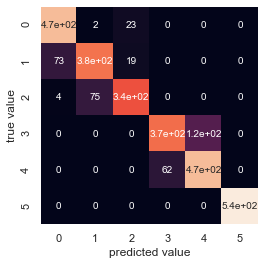

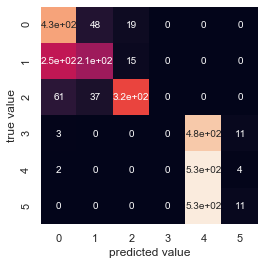

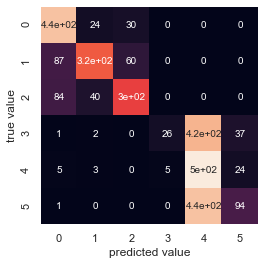

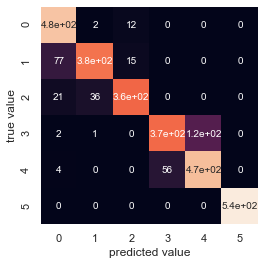

In [7]:
#MODEL: Raw TD features (TA)
rawTD_train = t_train
rawTD_test = t_test
print("Model: RawTD\n", rawTD_train.shape, rawTD_test.shape)  #feature vector size
rawTDModel = fs.makePipeline(rawTD_train, y_train, rawTD_test, y_test,degree=1) #returns model and prints results


#MODEL: Raw TD features (BA)
rawTD_trainBA = t_trainBA
rawTD_testBA = t_testBA
print("\nModel: RawTDBA\n", rawTD_trainBA.shape, rawTD_testBA.shape)  #feature vector size
rawTDModelBA = fs.makePipeline(rawTD_trainBA, y_train, rawTD_testBA, y_test, degree=1) #returns model and prints results


#MODEL: Raw TD features (BG)
rawTD_trainBG = t_trainBG
rawTD_testBG = t_testBG
print("\nModel: RawTDBG\n", rawTD_trainBG.shape, rawTD_testBG.shape)  #feature vector size
rawTDModelBG = fs.makePipeline(rawTD_trainBG, y_train, rawTD_testBG, y_test, degree=1) #returns model and prints results


#MODEL: Raw TD features (ALL)
rawTD_trainALL = np.concatenate((t_train, t_trainBA, t_trainBG),axis=1)
rawTD_testALL = np.concatenate((t_test, t_testBA, t_testBG),axis=1)
print("\nModel: RawTDALL\n", rawTD_trainALL.shape, rawTD_testALL.shape)  #feature vector size
rawTDModelALL = fs.makePipeline(rawTD_trainALL, y_train, rawTD_testALL, y_test, degree=1) #returns model and prints results

Model: RawFD
 (7352, 260) (2947, 260)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 9.47 s, sys: 87.9 ms, total: 9.56 s
Wall time: 11.1 s
CPU times: user 4.98 s, sys: 43.4 ms, total: 5.03 s
Wall time: 5.64 s
Train accuracy is 60.11 
Test accuracy is 58.50 
AUC: 0.483

Model: RawFDBA
 (7352, 260) (2947, 260)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 8.83 s, sys: 69.7 ms, total: 8.9 s
Wall time: 9.42 s
CPU times: user 5.02 s, sys: 48.8 ms, total: 5.07 s
Wall time: 5.57 s
Train accuracy is 60.16 
Test accuracy is 58.33 
AUC: 0.482

Model: RawFDBG
 (7352, 260) (2947, 260)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 9.62 s, sys: 39.2 ms, total: 9.66 s
Wall time: 9.72 s
CPU times: user 5.49 s, sys: 58.7 ms, total: 5.55 s
Wall time: 5.86 s
Train accuracy is 59.19 
Test accuracy is 57.72 
AUC: 0.478

Model: RawFDALL
 (7352, 780) (2947, 780)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 24.6 s, sys: 160 ms, total: 24.8 s
Wall time: 25.2 s
CPU times: user 14.9 s, sys: 150 ms, total: 15.1 s
Wall time: 15.7 s
Train accuracy is 62.05 
Test accuracy is 61.59 
AUC: 0.518


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


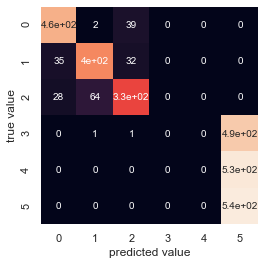

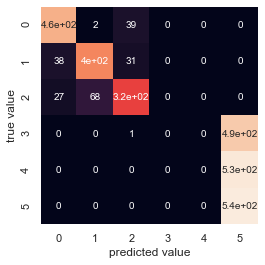

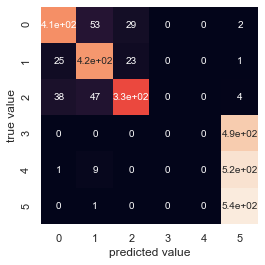

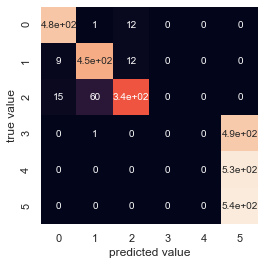

In [8]:
#MODEL: Raw FD features (TA)
rawFD_train = f_train
rawFD_test = f_test
print("Model: RawFD\n", rawFD_train.shape, rawFD_test.shape)  #feature vector size
rawFDModel = fs.makePipeline(rawFD_train, y_train, rawFD_test, y_test,degree=1) #returns model and prints results


#MODEL: Raw FD features (BA)
rawFD_trainBA = f_trainBA
rawFD_testBA = f_testBA
print("\nModel: RawFDBA\n", rawFD_trainBA.shape, rawFD_testBA.shape)  #feature vector size
rawFDModelBA = fs.makePipeline(rawFD_trainBA, y_train, rawFD_testBA, y_test, degree=1) #returns model and prints results


#MODEL: Raw FD features (BG)
rawFD_trainBG = f_trainBG
rawFD_testBG = f_testBG
print("\nModel: RawFDBG\n", rawFD_trainBG.shape, rawFD_testBG.shape)  #feature vector size
rawFDModelBG = fs.makePipeline(rawFD_trainBG, y_train, rawFD_testBG, y_test, degree=1) #returns model and prints results


#MODEL: Raw FD features (ALL)
rawFD_trainALL = np.concatenate((f_train, f_trainBA, f_trainBG),axis=1)
rawFD_testALL = np.concatenate((f_test, f_testBA, f_testBG),axis=1)
print("\nModel: RawFDALL\n", rawFD_trainALL.shape, rawFD_testALL.shape)  #feature vector size
rawFDModelALL = fs.makePipeline(rawFD_trainALL, y_train, rawFD_testALL, y_test, degree=1) #returns model and prints results

Model: Raw
 (7352, 772) (2947, 772)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 8.76 s, sys: 56.4 ms, total: 8.82 s
Wall time: 8.95 s
CPU times: user 6.87 s, sys: 27.4 ms, total: 6.9 s
Wall time: 6.98 s
Train accuracy is 93.34 
Test accuracy is 88.60 
AUC: 0.887

Model: RawBA
 (7352, 772) (2947, 772)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 24 s, sys: 85.2 ms, total: 24.1 s
Wall time: 24.3 s
CPU times: user 13.7 s, sys: 52.1 ms, total: 13.7 s
Wall time: 13.8 s
Train accuracy is 60.80 
Test accuracy is 58.50 
AUC: 0.548

Model: RawBG
 (7352, 772) (2947, 772)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 25.9 s, sys: 140 ms, total: 26 s
Wall time: 27.1 s
CPU times: user 15.9 s, sys: 137 ms, total: 16 s
Wall time: 17.9 s
Train accuracy is 63.83 
Test accuracy is 61.96 
AUC: 0.763

Model: RawALL
 (7352, 2316) (2947, 2316)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 29.3 s, sys: 640 ms, total: 30 s
Wall time: 34.1 s
CPU times: user 24.5 s, sys: 213 ms, total: 24.7 s
Wall time: 25.4 s
Train accuracy is 93.27 
Test accuracy is 90.77 
AUC: 0.910


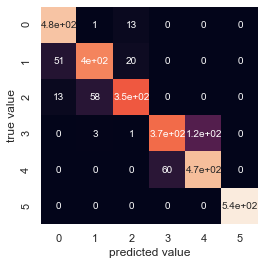

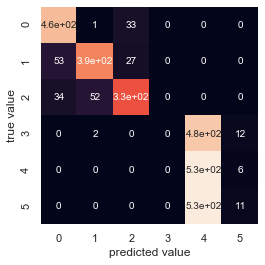

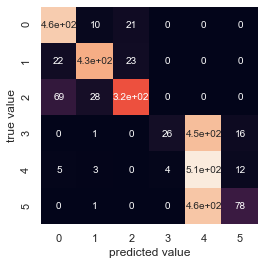

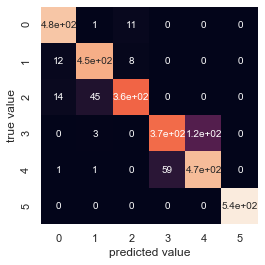

In [9]:
#MODEL: Raw TD&FD features (TA)
raw_train = np.concatenate((t_train, f_train),axis=1)
raw_test = np.concatenate((t_test, f_test),axis=1)
print("Model: Raw\n", raw_train.shape, raw_test.shape)  #feature vector size
rawFDModel = fs.makePipeline(raw_train, y_train, raw_test, y_test,degree=1) #returns model and prints results


#MODEL: Raw TD&FD features (BA)
raw_trainBA = np.concatenate((t_trainBA, f_trainBA),axis=1)
raw_testBA = np.concatenate((t_testBA, f_testBA),axis=1)
print("\nModel: RawBA\n", raw_trainBA.shape, raw_testBA.shape)  #feature vector size
rawModelBA = fs.makePipeline(raw_trainBA, y_train, raw_testBA, y_test, degree=1) #returns model and prints results


#MODEL: Raw TD&FD features (BG)
raw_trainBG = np.concatenate((t_trainBG, f_trainBG),axis=1)
raw_testBG = np.concatenate((t_testBG, f_testBG),axis=1)
print("\nModel: RawBG\n", raw_trainBG.shape, raw_testBG.shape)  #feature vector size
rawFDModelBG = fs.makePipeline(raw_trainBG, y_train, raw_testBG, y_test, degree=1) #returns model and prints results


#MODEL: Raw TD&FD features (ALL)
raw_trainALL = np.concatenate((t_train,t_trainBA,t_trainBG, f_train,f_trainBA,f_trainBG),axis=1)
raw_testALL = np.concatenate((t_test,t_testBA,t_testBG, f_test,f_testBA,f_testBG),axis=1)
print("\nModel: RawALL\n", raw_trainALL.shape, raw_testALL.shape)  #feature vector size
rawModelALL = fs.makePipeline(raw_trainALL, y_train, raw_testALL, y_test, degree=1) #returns model and prints results


Model: Ex
 (7352, 88) (2947, 88)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 10.4 s, sys: 83.5 ms, total: 10.5 s
Wall time: 10.8 s
CPU times: user 2.32 s, sys: 33.4 ms, total: 2.36 s
Wall time: 2.5 s
Train accuracy is 97.17 
Test accuracy is 64.74 
AUC: 0.655

Model: ExBA
 (7352, 88) (2947, 88)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 10.5 s, sys: 97.6 ms, total: 10.6 s
Wall time: 11.5 s
CPU times: user 2.39 s, sys: 34.8 ms, total: 2.42 s
Wall time: 2.67 s
Train accuracy is 96.21 
Test accuracy is 58.13 
AUC: 0.597

Model: ExBG
 (7352, 88) (2947, 88)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 11.6 s, sys: 153 ms, total: 11.7 s
Wall time: 13.3 s
CPU times: user 2.44 s, sys: 30.6 ms, total: 2.48 s
Wall time: 2.53 s
Train accuracy is 97.05 
Test accuracy is 48.90 
AUC: 0.506

Model: ExALL
 (7352, 264) (2947, 264)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 29.2 s, sys: 234 ms, total: 29.4 s
Wall time: 33.8 s
CPU times: user 6.83 s, sys: 71.8 ms, total: 6.9 s
Wall time: 7.13 s
Train accuracy is 99.99 
Test accuracy is 49.27 
AUC: 0.661


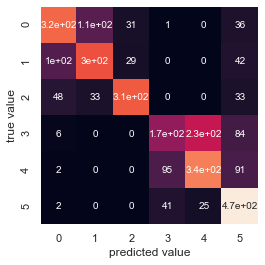

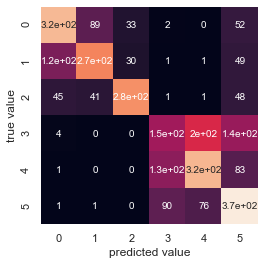

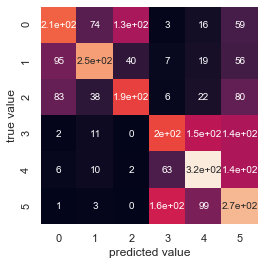

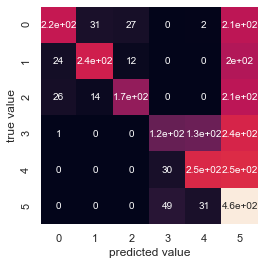

In [10]:
#MODEL: every possible feature EXcept for raw FD/TD inputs (TA)
exRaw_train = np.concatenate((tMus_train, tStds_train, fMus_train, fStds_train,
                              tSks_train, tKts_train, fSks_train, fKts_train,
                              tp_train, tnp_train, fp_train, fnp_train),axis=1)
exRaw_test = np.concatenate((tMus_test, tStds_test, fMus_test, fStds_test,
                             tSks_test, tKts_test, fSks_test, fKts_test,
                             tp_test, tnp_test, fp_test, fnp_test),axis=1)
print("Model: Ex\n", exRaw_train.shape, exRaw_test.shape) #feature vector size
exRawModel = fs.makePipeline(exRaw_train, y_train, exRaw_test, y_test,degree=1) #returns model and prints results


#MODEL: every possible feature EXcept for raw FD/TD inputs (BA)
exRaw_trainBA = np.concatenate((tMus_trainBA, tStds_trainBA, fMus_trainBA, fStds_trainBA,
                                tSks_trainBA, tKts_trainBA, fSks_trainBA, fKts_trainBA,
                                tp_trainBA, tnp_trainBA, fp_trainBA, fnp_trainBA),axis=1)
exRaw_testBA = np.concatenate((tMus_testBA, tStds_testBA, fMus_testBA, fStds_testBA,
                               tSks_testBA, tKts_testBA, fSks_testBA, fKts_testBA,
                               tp_testBA, tnp_testBA, fp_testBA, fnp_testBA),axis=1)
print("\nModel: ExBA\n", exRaw_trainBA.shape, exRaw_testBA.shape) #feature vector size
exRawModelBA = fs.makePipeline(exRaw_trainBA, y_train, exRaw_testBA, y_test,degree=1) #returns model and prints results


#MODEL: every possible features EXcept for raw FD/TD inputs (BG)
exRaw_trainBG = np.concatenate((tMus_trainBG, tStds_trainBG, fMus_trainBG, fStds_trainBG,
                                tSks_trainBG, tKts_trainBG, fSks_trainBG, fKts_trainBG,
                                tp_trainBG, tnp_trainBG, fp_trainBG, fnp_trainBG),axis=1)
exRaw_testBG = np.concatenate((tMus_testBG, tStds_testBG, fMus_testBG, fStds_testBG,
                               tSks_testBG, tKts_testBG, fSks_testBG, fKts_testBG,
                               tp_testBG, tnp_testBG, fp_testBG, fnp_testBG),axis=1)
print("\nModel: ExBG\n", exRaw_trainBG.shape, exRaw_testBG.shape) #feature vector size
exRawModelBG = fs.makePipeline(exRaw_trainBG, y_train, exRaw_testBG, y_test,degree=1) #returns model and prints results


#MODEL: every possible feature EXcept for raw FD/TD inputs (ALL)
exRaw_trainALL = np.concatenate((tMus_train, tStds_train, fMus_train, fStds_train,
                                 tSks_train, tKts_train, fSks_train, fKts_train,
                                 tp_train, tnp_train, fp_train, fnp_train,
                                tMus_trainBA, tStds_trainBA, fMus_trainBA, fStds_trainBA,
                                tSks_trainBA, tKts_trainBA, fSks_trainBA, fKts_trainBA,
                                tp_trainBA, tnp_trainBA, fp_trainBA, fnp_trainBA,
                                 tMus_trainBG, tStds_trainBG, fMus_trainBG, fStds_trainBG,
                                 tSks_trainBG, tKts_trainBG, fSks_trainBG, fKts_trainBG,
                                 tp_trainBG, tnp_trainBG, fp_trainBG, fnp_trainBG),axis=1)
exRaw_testALL = np.concatenate((tMus_test, tStds_test, fMus_test, fStds_test,
                                tSks_test, tKts_test, fSks_test, fKts_test,
                                tp_test, tnp_test, fp_test, fnp_test,
                               tMus_testBA, tStds_testBA, fMus_testBA, fStds_testBA,
                               tSks_testBA, tKts_testBA, fSks_testBA, fKts_testBA,
                               tp_testBA, tnp_testBA, fp_testBA, fnp_testBA,
                                 tMus_testBG, tStds_testBG, fMus_testBG, fStds_testBG,
                                 tSks_testBG, tKts_testBG, fSks_testBG, fKts_testBG,
                                 tp_testBG, tnp_testBG, fp_testBG, fnp_testBG),axis=1)
print("\nModel: ExALL\n", exRaw_trainALL.shape, exRaw_testALL.shape) #feature vector size
exRawModelALL = fs.makePipeline(exRaw_trainALL, y_train, exRaw_testALL, y_test,degree=1) #returns model and prints results

Model: Ev
 (7352, 860) (2947, 860)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 15 s, sys: 104 ms, total: 15.1 s
Wall time: 15.6 s
CPU times: user 9.97 s, sys: 83.8 ms, total: 10.1 s
Wall time: 10.8 s
Train accuracy is 94.78 
Test accuracy is 87.61 
AUC: 0.879

Model: EvBA
 (7352, 860) (2947, 860)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 23.3 s, sys: 183 ms, total: 23.5 s
Wall time: 23.9 s
CPU times: user 13.5 s, sys: 77.8 ms, total: 13.5 s
Wall time: 13.7 s
Train accuracy is 77.54 
Test accuracy is 71.19 
AUC: 0.713

Model: EvBG
 (7352, 860) (2947, 860)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 25 s, sys: 227 ms, total: 25.2 s
Wall time: 26.6 s
CPU times: user 14.9 s, sys: 178 ms, total: 15.1 s
Wall time: 16 s
Train accuracy is 79.20 
Test accuracy is 60.91 
AUC: 0.613

Model: EvALL
 (7352, 2580) (2947, 2580)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 53 s, sys: 570 ms, total: 53.6 s
Wall time: 55 s
CPU times: user 32.8 s, sys: 227 ms, total: 33.1 s
Wall time: 33.9 s
Train accuracy is 97.42 
Test accuracy is 90.09 
AUC: 0.908


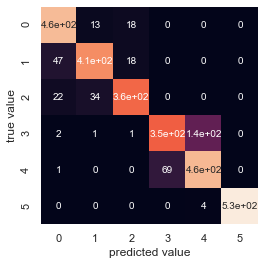

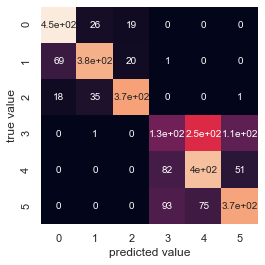

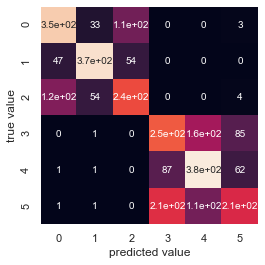

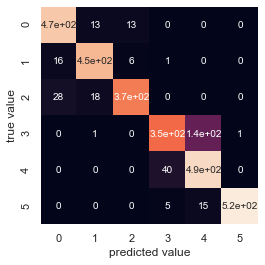

In [11]:
#MODEL: Every possible feature + raw FD/TD inputs (TA)
ev_train = np.concatenate((tMus_train, tStds_train, fMus_train, fStds_train,
                           tSks_train, tKts_train, fSks_train, fKts_train,
                           tp_train, tnp_train, fp_train, fnp_train,
                           t_train, f_train),axis=1)
ev_test = np.concatenate((tMus_test, tStds_test, fMus_test, fStds_test,
                          tSks_test, tKts_test, fSks_test, fKts_test,
                          tp_test, tnp_test, fp_test, fnp_test,
                          t_test, f_test),axis=1)
print("Model: Ev\n", ev_train.shape, ev_test.shape) #feature vector size
evModel = fs.makePipeline(ev_train, y_train, ev_test, y_test,degree=1) #returns model and prints results


#MODEL: Every possible feature + raw FD/TD inputs (BA)
ev_trainBA = np.concatenate((tMus_trainBA, tStds_trainBA, fMus_trainBA, fStds_trainBA,
                             tSks_trainBA, tKts_trainBA, fSks_trainBA, fKts_trainBA,
                             tp_trainBA, tnp_trainBA, fp_trainBA, fnp_trainBA,
                             t_trainBA, f_trainBA),axis=1)
ev_testBA = np.concatenate((tMus_testBA, tStds_testBA, fMus_testBA, fStds_testBA,
                            tSks_testBA, tKts_testBA, fSks_testBA, fKts_testBA,
                            tp_testBA, tnp_testBA, fp_testBA, fnp_testBA,
                            t_testBA, f_testBA),axis=1)
print("\nModel: EvBA\n", ev_trainBA.shape, ev_testBA.shape) #feature vector size
evModelBA = fs.makePipeline(ev_trainBA, y_train, ev_testBA, y_test,degree=1) #returns model and prints results


#MODEL: Every possible feature + raw FD/TD inputs (BG)
ev_trainBG = np.concatenate((tMus_trainBG, tStds_trainBG, fMus_trainBG, fStds_trainBG,
                             tSks_trainBG, tKts_trainBG, fSks_trainBG, fKts_trainBG,
                             tp_trainBG, tnp_trainBG, fp_trainBG, fnp_trainBG,
                             t_trainBA, f_trainBA),axis=1)
ev_testBG = np.concatenate((tMus_testBG, tStds_testBG, fMus_testBG, fStds_testBG,
                            tSks_testBG, tKts_testBG, fSks_testBG, fKts_testBG,
                            tp_testBG, tnp_testBG, fp_testBG, fnp_testBG,
                            t_testBG, f_testBG),axis=1)
print("\nModel: EvBG\n", ev_trainBG.shape, ev_testBG.shape) #feature vector size
evModelBG = fs.makePipeline(ev_trainBG, y_train, ev_testBG, y_test,degree=1) #returns model and prints results


#MODEL: Every possible feature + raw FD/TD inputs (ALL)
ev_trainALL = np.concatenate((tMus_train, tStds_train, fMus_train, fStds_train,
                              tSks_train, tKts_train, fSks_train, fKts_train,
                              tp_train, tnp_train, fp_train, fnp_train,
                              t_train, f_train,
                               tMus_trainBA, tStds_trainBA, fMus_trainBA, fStds_trainBA,
                               tSks_trainBA, tKts_trainBA, fSks_trainBA, fKts_trainBA,
                               tp_trainBA, tnp_trainBA, fp_trainBA, fnp_trainBA,
                               t_trainBA, f_trainBA,
                                tMus_trainBG, tStds_trainBG, fMus_trainBG, fStds_trainBG,
                                tSks_trainBG, tKts_trainBG, fSks_trainBG, fKts_trainBG,
                                tp_trainBG, tnp_trainBG, fp_trainBG, fnp_trainBG,
                                t_trainBG, f_trainBG),axis=1)
ev_testALL = np.concatenate((tMus_test, tStds_test, fMus_test, fStds_test,
                             tSks_test, tKts_test, fSks_test, fKts_test,
                             tp_test, tnp_test, fp_test, fnp_test,
                             t_test, f_test,
                              tMus_testBA, tStds_testBA, fMus_testBA, fStds_testBA,
                              tSks_testBA, tKts_testBA, fSks_testBA, fKts_testBA,
                              tp_testBA, tnp_testBA, fp_testBA, fnp_testBA,
                              t_testBA, f_testBA,
                               tMus_testBG, tStds_testBG, fMus_testBG, fStds_testBG,
                               tSks_testBG, tKts_testBG, fSks_testBG, fKts_testBG,
                               tp_testBG, tnp_testBG, fp_testBG, fnp_testBG,
                               t_testBG, f_testBG),axis=1)
print("\nModel: EvALL\n", ev_trainALL.shape, ev_testALL.shape) #feature vector size
evModelALL = fs.makePipeline(ev_trainALL, y_train, ev_testALL, y_test,degree=1) #returns model and prints results

Model: EvTD
 (7352, 600) (2947, 600)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 14.1 s, sys: 128 ms, total: 14.2 s
Wall time: 14.7 s
CPU times: user 7.92 s, sys: 57.6 ms, total: 7.98 s
Wall time: 8.09 s
Train accuracy is 94.75 
Test accuracy is 84.19 
AUC: 0.843

Model: EvTDBA
 (7352, 600) (2947, 600)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 18.6 s, sys: 155 ms, total: 18.7 s
Wall time: 19.1 s
CPU times: user 9.67 s, sys: 39 ms, total: 9.71 s
Wall time: 9.74 s
Train accuracy is 77.88 
Test accuracy is 67.36 
AUC: 0.676

Model: EvTDBG
 (7352, 600) (2947, 600)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 21.4 s, sys: 364 ms, total: 21.8 s
Wall time: 24.8 s
CPU times: user 11.3 s, sys: 158 ms, total: 11.5 s
Wall time: 11.8 s
Train accuracy is 79.41 
Test accuracy is 59.48 
AUC: 0.602

Model: EvTDALL
 (7352, 1800) (2947, 1800)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 45.2 s, sys: 186 ms, total: 45.4 s
Wall time: 45.5 s
CPU times: user 23.5 s, sys: 78.6 ms, total: 23.6 s
Wall time: 23.6 s
Train accuracy is 97.78 
Test accuracy is 88.43 
AUC: 0.890


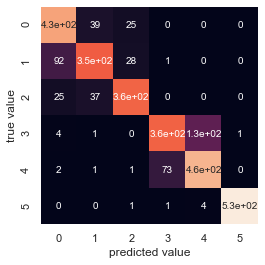

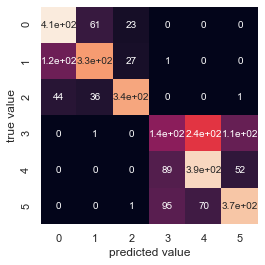

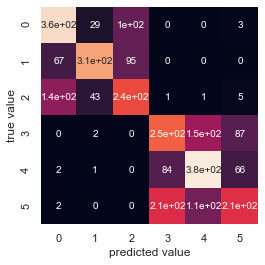

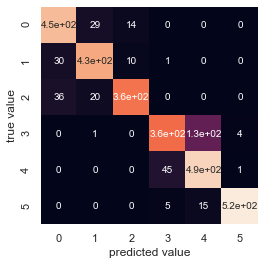

In [12]:
#MODEL: Every possible feature + raw TD inputs (TA)
evTD_train = np.concatenate((tMus_train, tStds_train, fMus_train, fStds_train,
                           tSks_train, tKts_train, fSks_train, fKts_train,
                           tp_train, tnp_train, fp_train, fnp_train,
                           t_train),axis=1)
evTD_test = np.concatenate((tMus_test, tStds_test, fMus_test, fStds_test,
                          tSks_test, tKts_test, fSks_test, fKts_test,
                          tp_test, tnp_test, fp_test, fnp_test,
                          t_test),axis=1)
print("Model: EvTD\n", evTD_train.shape, evTD_test.shape) #feature vector size
evTDModel = fs.makePipeline(evTD_train, y_train, evTD_test, y_test,degree=1) #returns model and prints results


#MODEL: Every possible feature + raw TD inputs (BA)
evTD_trainBA = np.concatenate((tMus_trainBA, tStds_trainBA, fMus_trainBA, fStds_trainBA,
                             tSks_trainBA, tKts_trainBA, fSks_trainBA, fKts_trainBA,
                             tp_trainBA, tnp_trainBA, fp_trainBA, fnp_trainBA,
                             t_trainBA),axis=1)
evTD_testBA = np.concatenate((tMus_testBA, tStds_testBA, fMus_testBA, fStds_testBA,
                            tSks_testBA, tKts_testBA, fSks_testBA, fKts_testBA,
                            tp_testBA, tnp_testBA, fp_testBA, fnp_testBA,
                            t_testBA),axis=1)
print("\nModel: EvTDBA\n", evTD_trainBA.shape, evTD_testBA.shape) #feature vector size
evTDModelBA = fs.makePipeline(evTD_trainBA, y_train, evTD_testBA, y_test,degree=1) #returns model and prints results


#MODEL: Every possible feature + raw TD inputs (BG)
evTD_trainBG = np.concatenate((tMus_trainBG, tStds_trainBG, fMus_trainBG, fStds_trainBG,
                             tSks_trainBG, tKts_trainBG, fSks_trainBG, fKts_trainBG,
                             tp_trainBG, tnp_trainBG, fp_trainBG, fnp_trainBG,
                             t_trainBA),axis=1)
evTD_testBG = np.concatenate((tMus_testBG, tStds_testBG, fMus_testBG, fStds_testBG,
                            tSks_testBG, tKts_testBG, fSks_testBG, fKts_testBG,
                            tp_testBG, tnp_testBG, fp_testBG, fnp_testBG,
                            t_testBG),axis=1)
print("\nModel: EvTDBG\n", evTD_trainBG.shape, evTD_testBG.shape) #feature vector size
evTDModelBG = fs.makePipeline(evTD_trainBG, y_train, evTD_testBG, y_test,degree=1) #returns model and prints results


#MODEL: Every possible feature + raw TD inputs (ALL)
evTD_trainALL = np.concatenate((tMus_train, tStds_train, fMus_train, fStds_train,
                              tSks_train, tKts_train, fSks_train, fKts_train,
                              tp_train, tnp_train, fp_train, fnp_train,
                              t_train,
                               tMus_trainBA, tStds_trainBA, fMus_trainBA, fStds_trainBA,
                               tSks_trainBA, tKts_trainBA, fSks_trainBA, fKts_trainBA,
                               tp_trainBA, tnp_trainBA, fp_trainBA, fnp_trainBA,
                               t_trainBA,
                                tMus_trainBG, tStds_trainBG, fMus_trainBG, fStds_trainBG,
                                tSks_trainBG, tKts_trainBG, fSks_trainBG, fKts_trainBG,
                                tp_trainBG, tnp_trainBG, fp_trainBG, fnp_trainBG,
                                t_trainBG),axis=1)
evTD_testALL = np.concatenate((tMus_test, tStds_test, fMus_test, fStds_test,
                             tSks_test, tKts_test, fSks_test, fKts_test,
                             tp_test, tnp_test, fp_test, fnp_test,
                             t_test,
                              tMus_testBA, tStds_testBA, fMus_testBA, fStds_testBA,
                              tSks_testBA, tKts_testBA, fSks_testBA, fKts_testBA,
                              tp_testBA, tnp_testBA, fp_testBA, fnp_testBA,
                              t_testBA,
                               tMus_testBG, tStds_testBG, fMus_testBG, fStds_testBG,
                               tSks_testBG, tKts_testBG, fSks_testBG, fKts_testBG,
                               tp_testBG, tnp_testBG, fp_testBG, fnp_testBG,
                               t_testBG),axis=1)
print("\nModel: EvTDALL\n", evTD_trainALL.shape, evTD_testALL.shape) #feature vector size
evTDModelALL = fs.makePipeline(evTD_trainALL, y_train, evTD_testALL, y_test,degree=1) #returns model and prints results

Model: EvFD
 (7352, 348) (2947, 348)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 11.7 s, sys: 38.1 ms, total: 11.7 s
Wall time: 11.7 s
CPU times: user 5.61 s, sys: 25 ms, total: 5.64 s
Wall time: 5.64 s
Train accuracy is 91.24 
Test accuracy is 79.78 
AUC: 0.805

Model: EvFDBA
 (7352, 348) (2947, 348)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 14.3 s, sys: 157 ms, total: 14.5 s
Wall time: 15.2 s
CPU times: user 7.52 s, sys: 164 ms, total: 7.69 s
Wall time: 8.86 s
Train accuracy is 82.15 
Test accuracy is 70.00 
AUC: 0.700

Model: EvFDBG
 (7352, 348) (2947, 348)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 15 s, sys: 39.1 ms, total: 15 s
Wall time: 15 s
CPU times: user 6.28 s, sys: 27.6 ms, total: 6.31 s
Wall time: 6.32 s
Train accuracy is 84.24 
Test accuracy is 59.82 
AUC: 0.602

Model: EvFDALL
 (7352, 1044) (2947, 1044)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 45.8 s, sys: 476 ms, total: 46.3 s
Wall time: 49.7 s
CPU times: user 19.3 s, sys: 262 ms, total: 19.6 s
Wall time: 21.6 s
Train accuracy is 96.07 
Test accuracy is 78.01 
AUC: 0.785


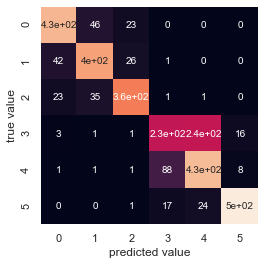

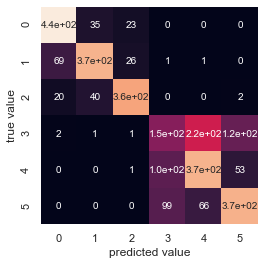

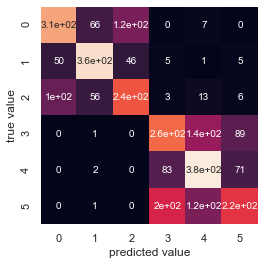

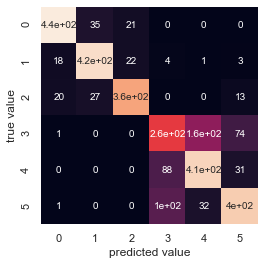

In [13]:
#MODEL: Every possible feature + raw FD inputs (TA)
evFD_train = np.concatenate((tMus_train, tStds_train, fMus_train, fStds_train,
                           tSks_train, tKts_train, fSks_train, fKts_train,
                           tp_train, tnp_train, fp_train, fnp_train,
                           f_train),axis=1)
evFD_test = np.concatenate((tMus_test, tStds_test, fMus_test, fStds_test,
                          tSks_test, tKts_test, fSks_test, fKts_test,
                          tp_test, tnp_test, fp_test, fnp_test,
                          f_test),axis=1)
print("Model: EvFD\n", evFD_train.shape, evFD_test.shape) #feature vector size
evFDModel = fs.makePipeline(evFD_train, y_train, evFD_test, y_test,degree=1) #returns model and prints results


#MODEL: Every possible feature + raw FD inputs (BA)
evFD_trainBA = np.concatenate((tMus_trainBA, tStds_trainBA, fMus_trainBA, fStds_trainBA,
                             tSks_trainBA, tKts_trainBA, fSks_trainBA, fKts_trainBA,
                             tp_trainBA, tnp_trainBA, fp_trainBA, fnp_trainBA,
                             f_trainBA),axis=1)
evFD_testBA = np.concatenate((tMus_testBA, tStds_testBA, fMus_testBA, fStds_testBA,
                            tSks_testBA, tKts_testBA, fSks_testBA, fKts_testBA,
                            tp_testBA, tnp_testBA, fp_testBA, fnp_testBA,
                            f_testBA),axis=1)
print("\nModel: EvFDBA\n", evFD_trainBA.shape, evFD_testBA.shape) #feature vector size
evFDModelBA = fs.makePipeline(evFD_trainBA, y_train, evFD_testBA, y_test,degree=1) #returns model and prints results


#MODEL: Every possible feature + raw FD inputs (BG)
evFD_trainBG = np.concatenate((tMus_trainBG, tStds_trainBG, fMus_trainBG, fStds_trainBG,
                             tSks_trainBG, tKts_trainBG, fSks_trainBG, fKts_trainBG,
                             tp_trainBG, tnp_trainBG, fp_trainBG, fnp_trainBG,
                             f_trainBA),axis=1)
evFD_testBG = np.concatenate((tMus_testBG, tStds_testBG, fMus_testBG, fStds_testBG,
                            tSks_testBG, tKts_testBG, fSks_testBG, fKts_testBG,
                            tp_testBG, tnp_testBG, fp_testBG, fnp_testBG,
                            f_testBG),axis=1)
print("\nModel: EvFDBG\n", evFD_trainBG.shape, evFD_testBG.shape) #feature vector size
evFDModelBG = fs.makePipeline(evFD_trainBG, y_train, evFD_testBG, y_test,degree=1) #returns model and prints results


#MODEL: Every possible feature + raw FD inputs (ALL)
evFD_trainALL = np.concatenate((tMus_train, tStds_train, fMus_train, fStds_train,
                              tSks_train, tKts_train, fSks_train, fKts_train,
                              tp_train, tnp_train, fp_train, fnp_train,
                              f_train,
                               tMus_trainBA, tStds_trainBA, fMus_trainBA, fStds_trainBA,
                               tSks_trainBA, tKts_trainBA, fSks_trainBA, fKts_trainBA,
                               tp_trainBA, tnp_trainBA, fp_trainBA, fnp_trainBA,
                               f_trainBA,
                                tMus_trainBG, tStds_trainBG, fMus_trainBG, fStds_trainBG,
                                tSks_trainBG, tKts_trainBG, fSks_trainBG, fKts_trainBG,
                                tp_trainBG, tnp_trainBG, fp_trainBG, fnp_trainBG,
                                f_trainBG),axis=1)
evFD_testALL = np.concatenate((tMus_test, tStds_test, fMus_test, fStds_test,
                             tSks_test, tKts_test, fSks_test, fKts_test,
                             tp_test, tnp_test, fp_test, fnp_test,
                             f_test,
                              tMus_testBA, tStds_testBA, fMus_testBA, fStds_testBA,
                              tSks_testBA, tKts_testBA, fSks_testBA, fKts_testBA,
                              tp_testBA, tnp_testBA, fp_testBA, fnp_testBA,
                              f_testBA,
                               tMus_testBG, tStds_testBG, fMus_testBG, fStds_testBG,
                               tSks_testBG, tKts_testBG, fSks_testBG, fKts_testBG,
                               tp_testBG, tnp_testBG, fp_testBG, fnp_testBG,
                               f_testBG),axis=1)
print("\nModel: EvFDALL\n", evFD_trainALL.shape, evFD_testALL.shape) #feature vector size
evFDModelALL = fs.makePipeline(evFD_trainALL, y_train, evFD_testALL, y_test,degree=1) #returns model and prints results

Model: TDEvTD
 (7352, 556) (2947, 556)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 7.94 s, sys: 46.1 ms, total: 7.99 s
Wall time: 8.11 s
CPU times: user 5.49 s, sys: 21.2 ms, total: 5.51 s
Wall time: 5.53 s
Train accuracy is 93.42 
Test accuracy is 86.90 
AUC: 0.870

Model: TDEvTDBA
 (7352, 556) (2947, 556)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 16 s, sys: 83 ms, total: 16.1 s
Wall time: 16.2 s
CPU times: user 9.3 s, sys: 32.5 ms, total: 9.33 s
Wall time: 9.35 s
Train accuracy is 67.66 
Test accuracy is 61.83 
AUC: 0.625

Model: TDEvTDBG
 (7352, 556) (2947, 556)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 15.5 s, sys: 48.3 ms, total: 15.6 s
Wall time: 15.6 s
CPU times: user 9.94 s, sys: 70.9 ms, total: 10 s
Wall time: 10.1 s
Train accuracy is 70.89 
Test accuracy is 53.41 
AUC: 0.549

Model: TDEvTDALL
 (7352, 1668) (2947, 1668)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 23.2 s, sys: 237 ms, total: 23.4 s
Wall time: 24.7 s
CPU times: user 16.5 s, sys: 81.9 ms, total: 16.5 s
Wall time: 16.8 s
Train accuracy is 95.50 
Test accuracy is 89.35 
AUC: 0.899


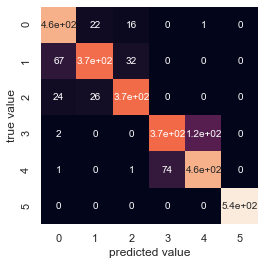

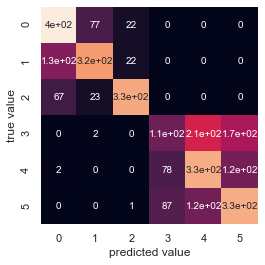

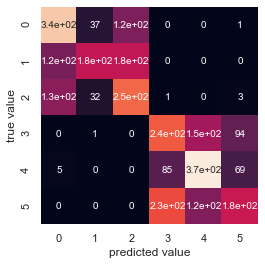

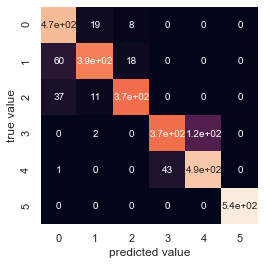

In [14]:
#MODEL: Every possible TD feature + raw TD inputs (TA)
TDevTD_train = np.concatenate((tMus_train, tStds_train,
                             tSks_train, tKts_train,
                             tp_train, tnp_train,
                             t_train),axis=1)
TDevTD_test = np.concatenate((tMus_test, tStds_test,
                            tSks_test, tKts_test,
                            tp_test, tnp_test,
                            t_test),axis=1)
print("Model: TDEvTD\n", TDevTD_train.shape, TDevTD_test.shape) #feature vector size
TDevTDModel = fs.makePipeline(TDevTD_train, y_train, TDevTD_test, y_test,degree=1) #returns model and prints results


#MODEL: Every possible TD feature + raw TD inputs (BA)
TDevTD_trainBA = np.concatenate((tMus_trainBA, tStds_trainBA,
                             tSks_trainBA, tKts_trainBA,
                             tp_trainBA, tnp_trainBA,
                             t_trainBA),axis=1)
TDevTD_testBA = np.concatenate((tMus_testBA, tStds_testBA,
                            tSks_testBA, tKts_testBA,
                            tp_testBA, tnp_testBA,
                            t_testBA),axis=1)
print("\nModel: TDEvTDBA\n", TDevTD_trainBA.shape, TDevTD_testBA.shape) #feature vector size
TDevTDModelBA = fs.makePipeline(TDevTD_trainBA, y_train, TDevTD_testBA, y_test,degree=1) #returns model and prints results


#MODEL: Every possible TD feature + raw TD inputs (BG)
TDevTD_trainBG = np.concatenate((tMus_trainBG, tStds_trainBG, 
                               tSks_trainBG, tKts_trainBG,
                               tp_trainBG, tnp_trainBG,
                               t_trainBA,),axis=1)
TDevTD_testBG = np.concatenate((tMus_testBG, tStds_testBG,
                              tSks_testBG, tKts_testBG,
                              tp_testBG, tnp_testBG,
                              t_testBG),axis=1)
print("\nModel: TDEvTDBG\n", TDevTD_trainBG.shape, TDevTD_testBG.shape) #feature vector size
TDevTDModelBG = fs.makePipeline(TDevTD_trainBG, y_train, TDevTD_testBG, y_test,degree=1) #returns model and prints results


#MODEL: Every possible TD feature + raw TD inputs (ALL)
TDevTD_trainALL = np.concatenate((tMus_train, tStds_train,
                                tSks_train, tKts_train,
                                tp_train, tnp_train,
                                t_train,
                                 tMus_trainBA, tStds_trainBA,
                                 tSks_trainBA, tKts_trainBA,
                                 tp_trainBA, tnp_trainBA,
                                 t_trainBA,
                                  tMus_trainBG, tStds_trainBG,
                                  tSks_trainBG, tKts_trainBG,
                                  tp_trainBG, tnp_trainBG,
                                  t_trainBG),axis=1)
TDevTD_testALL = np.concatenate((tMus_test, tStds_test,
                               tSks_test, tKts_test,
                               tp_test, tnp_test,
                               t_test, 
                                tMus_testBA, tStds_testBA,
                                tSks_testBA, tKts_testBA,
                                tp_testBA, tnp_testBA,
                                t_testBA,
                                 tMus_testBG, tStds_testBG,
                                 tSks_testBG, tKts_testBG,
                                 tp_testBG, tnp_testBG,
                                 t_testBG),axis=1)
print("\nModel: TDEvTDALL\n", TDevTD_trainALL.shape, TDevTD_testALL.shape) #feature vector size
TDevTDModelALL = fs.makePipeline(TDevTD_trainALL, y_train, TDevTD_testALL, y_test,degree=1) #returns model and prints results

Model: FDEvFD
 (7352, 304) (2947, 304)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 10.5 s, sys: 33.9 ms, total: 10.5 s
Wall time: 10.5 s
CPU times: user 5.54 s, sys: 51.3 ms, total: 5.59 s
Wall time: 5.79 s
Train accuracy is 73.68 
Test accuracy is 65.90 
AUC: 0.662

Model: FDEvFDBA
 (7352, 304) (2947, 304)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 11.2 s, sys: 77 ms, total: 11.3 s
Wall time: 11.7 s
CPU times: user 5.57 s, sys: 54.8 ms, total: 5.63 s
Wall time: 5.79 s
Train accuracy is 74.09 
Test accuracy is 67.22 
AUC: 0.669

Model: FDEvFDBG
 (7352, 304) (2947, 304)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 13.8 s, sys: 165 ms, total: 13.9 s
Wall time: 15.7 s
CPU times: user 6.03 s, sys: 77.7 ms, total: 6.1 s
Wall time: 6.55 s
Train accuracy is 71.69 
Test accuracy is 56.26 
AUC: 0.572

Model: FDEvFDALL
 (7352, 912) (2947, 912)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 35.4 s, sys: 222 ms, total: 35.6 s
Wall time: 36 s
CPU times: user 15.2 s, sys: 58.5 ms, total: 15.3 s
Wall time: 15.3 s
Train accuracy is 86.02 
Test accuracy is 72.58 
AUC: 0.729


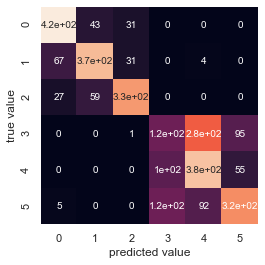

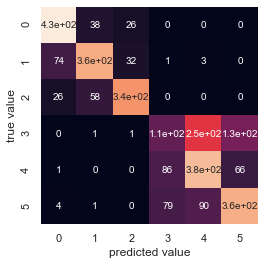

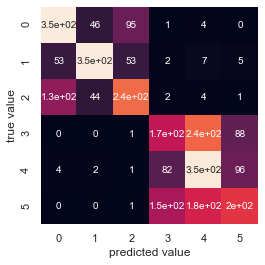

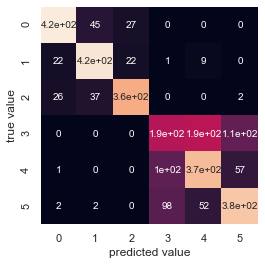

In [15]:
#MODEL: Every possible FD feature + raw FD inputs (TA)
FDevFD_train = np.concatenate((fMus_train, fStds_train,
                             fSks_train, fKts_train,
                             fp_train, fnp_train,
                             f_train),axis=1)
FDevFD_test = np.concatenate((fMus_test, fStds_test,
                            fSks_test, fKts_test,
                            fp_test, fnp_test,
                            f_test),axis=1)
print("Model: FDEvFD\n", FDevFD_train.shape, FDevFD_test.shape) #feature vector size
FDevFDModel = fs.makePipeline(FDevFD_train, y_train, FDevFD_test, y_test,degree=1) #returns model and prints results


#MODEL: Every possible FD feature + raw FD inputs (BA)
FDevFD_trainBA = np.concatenate((fMus_trainBA, fStds_trainBA,
                               fSks_trainBA, fKts_trainBA,
                               fp_trainBA, fnp_trainBA,
                               f_trainBA),axis=1)
FDevFD_testBA = np.concatenate((fMus_testBA, fStds_testBA,
                              fSks_testBA, fKts_testBA,
                              fp_testBA, fnp_testBA,
                              f_testBA),axis=1)
print("\nModel: FDEvFDBA\n", FDevFD_trainBA.shape, FDevFD_testBA.shape) #feature vector size
FDevFDModelBA = fs.makePipeline(FDevFD_trainBA, y_train, FDevFD_testBA, y_test,degree=1) #returns model and prints results


#MODEL: Every possible FD feature + raw FD inputs (BG)
FDevFD_trainBG = np.concatenate((fMus_trainBG, fStds_trainBG, 
                               fSks_trainBG, fKts_trainBG,
                               fp_trainBG, fnp_trainBG,
                               f_trainBA,),axis=1)
FDevFD_testBG = np.concatenate((fMus_testBG, fStds_testBG,
                              fSks_testBG, fKts_testBG,
                              fp_testBG, fnp_testBG,
                              f_testBG),axis=1)
print("\nModel: FDEvFDBG\n", FDevFD_trainBG.shape, FDevFD_testBG.shape) #feature vector size
FDevFDModelBG = fs.makePipeline(FDevFD_trainBG, y_train, FDevFD_testBG, y_test,degree=1) #returns model and prints results


#MODEL: Every possible FD feature + raw FD inputs (ALL)
FDevFD_trainALL = np.concatenate((fMus_train, fStds_train,
                                fSks_train, fKts_train,
                                fp_train, fnp_train,
                                f_train,
                                 fMus_trainBA, fStds_trainBA,
                                 fSks_trainBA, fKts_trainBA,
                                 fp_trainBA, fnp_trainBA,
                                 f_trainBA,
                                  fMus_trainBG, fStds_trainBG,
                                  fSks_trainBG, fKts_trainBG,
                                  fp_trainBG, fnp_trainBG,
                                  f_trainBG),axis=1)
FDevFD_testALL = np.concatenate((fMus_test, fStds_test,
                               fSks_test, fKts_test,
                               fp_test, fnp_test,
                               f_test, 
                                fMus_testBA, fStds_testBA,
                                fSks_testBA, fKts_testBA,
                                fp_testBA, fnp_testBA,
                                f_testBA,
                                 fMus_testBG, fStds_testBG,
                                 fSks_testBG, fKts_testBG,
                                 fp_testBG, fnp_testBG,
                                 f_testBG),axis=1)
print("\nModel: FDEvFDALL\n", FDevFD_trainALL.shape, FDevFD_testALL.shape) #feature vector size
FDevFDModelALL = fs.makePipeline(FDevFD_trainALL, y_train, FDevFD_testALL, y_test,degree=1) #returns model and prints results

Best Performing So Far:

All features

    &

Raw FD+TD 

    &

Total Accel, Body Accel, Body Gyro (ALL)

    & 
(with polynomials degree 1) 

    = 90.8% accuracy

